In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import numpyro
# from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import pandas as pd
import corner
import scipy.stats as stats
from tqdm import tqdm

from msc.cache_handler import get_samples_df
from msc.plot_utils import set_size
from msc.config_utils import config
from msc.prior_utils import get_events_df_from_config, events_df_to_circadian_hist
from msc.prior_utils import PercentileOfScore
from msc.time_utils import SEC, MIN, HOUR

plt.style.use(['science', 'no-latex'])
plt.viridis()

%load_ext autoreload
%autoreload 2

<Figure size 252x189 with 0 Axes>

In [2]:
# get data
dataset_id = config['dataset_id']
samples_df = get_samples_df(dataset_id, with_events=True, with_time_to_event=True)

In [3]:
# split train/test
t_max = config['t_max']
samples_df['set'] = samples_df['time'].apply(lambda t: 'train' if t < t_max else 'test')

In [4]:
horizon = 0     # detection
# horizon = 5 * SEC
# horizon = 30 * MIN  # prediction
samples_df['class'] = samples_df['time_to_event'].apply(lambda x: 1 if x <= horizon else 0)

## Calculate likelihood

In [5]:
train_idxs = samples_df[samples_df['set'] == 'train'].index
test_idxs = samples_df[samples_df['set'] == 'test'].index

In [6]:
gmm = GaussianMixture(2)
gmm.fit(np.vstack(samples_df.loc[train_idxs ,'embedding']))


GaussianMixture(n_components=2)

In [7]:
gmm.score_samples(np.vstack(samples_df['embedding']))

array([-47.2407318 ,  -4.74726098,  -7.49730495, ...,  -5.72108814,
       -10.14968124, -10.23913238])

In [8]:
samples_df['p_E'] = gmm.score_samples(np.vstack(samples_df['embedding']))

In [9]:
samples_df['P_E'] = np.array(PercentileOfScore(samples_df.loc[train_idxs, 'p_E'].to_numpy()).pct(samples_df['p_E'].to_numpy()))/100

In [10]:
thresh = 0.05
arr = samples_df.loc[train_idxs, 'p_E'].to_numpy()
N = len(arr)
cutoff_value = np.partition(arr, int(thresh * N))[int(thresh * N)]

In [11]:
samples_df['not_S'] = samples_df['p_E'] >= cutoff_value

In [12]:
cutoff_value

-16.71543251144814

In [13]:
samples_df.loc[samples_df['not_S'], 'P_E_|_not_S'] = np.array(PercentileOfScore(samples_df.loc[train_idxs.intersection(samples_df['not_S'].index), 'p_E'].to_numpy()).pct(samples_df.loc[samples_df['not_S'], 'p_E'].to_numpy()))/100

In [14]:
events_df = get_events_df_from_config()
circadian_hist = events_df_to_circadian_hist(events_df)

In [15]:
circadian_hist

array([2, 1, 1, 3, 2, 5, 1, 3, 2, 2, 1, 2, 2, 1, 2, 0, 1, 3, 0, 2, 1, 2,
       4, 2])

In [16]:
from msc.prior_utils import vm_density
from functools import partial

def vm_prior(t: float):
    """
    the von Mises mixture model prior over the 24 hour cycle
    Parameters
    ----------
    t       time

    Returns
    -------

    """
    N = 24  # hours
    mus = np.arange(N) + 0.5

    def vm_mixture(x): return sum(
        [circadian_hist[i] * partial(vm_density, mu=mu)(x) for i, mu in enumerate(mus)])

    return vm_mixture(t) / np.trapz(vm_mixture(mus))


In [17]:
samples_df['P_S_|_t'] = vm_prior(samples_df['time'])


In [18]:
samples_df['P_not_S_|_t'] = 1 - samples_df['P_S_|_t']

In [19]:
samples_df['P_not_S_|_E'] = samples_df['P_E_|_not_S'] * samples_df['P_not_S_|_t'] / samples_df['P_E']

In [20]:
samples_df['P_S_|_E'] = 1 - samples_df['P_not_S_|_E']

In [21]:
samples_df.loc[~samples_df['not_S'], 'P_S_|_E'] = 1

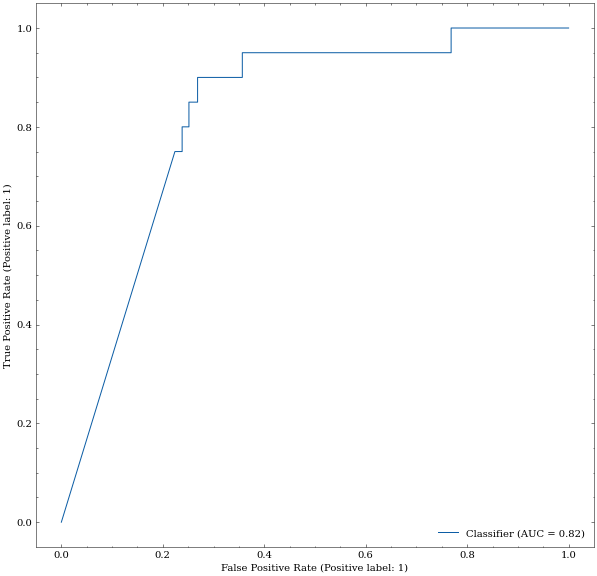

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
RocCurveDisplay.from_predictions(samples_df.loc[samples_df['set'] == 'test', 'class'], samples_df.loc[samples_df['set'] == 'test', 'P_S_|_E'], ax=ax)